<a href="https://colab.research.google.com/github/SabtheCrab/CS-175-Final-Project/blob/master/CS175_project_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS 175 Final Project: Humback Whale Identification**

**Group Member 1:**

Name: Sabrina Will

**Group Member 2:**

Name: Jeffrey Lee Ye

CREDITS FOR BOUNDING BOX CROPPED DATASET: https://www.kaggle.com/josemontiel/humpback-whale-bounding-box-cropped-dataset/output

In [14]:
#We are using a data set, which originally came from the kaggle competition. However, many of the images suffered from misalignment issues and have 
#large amounts of background space we dont need our AI to consider when looking at whale flukes. As such, someone blessed competitors with a
#dataset that reformats all original images and crops out just the whale fluke itself. This is the data we are using in our project. 

from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
%cd /content/drive/My\ Drive/CS\ 175\ Final\ Project/data

/content/drive/My Drive/CS 175 Final Project/data


In [46]:
import copy, cv2, json, os, time, torch, torchvision

from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
from PIL import Image
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.utils.data as data
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
from torchvision import transforms
import torchvision.datasets as datasets

import pandas as pd

import seaborn as sns

df = pd.read_csv('train.csv')
testDf = pd.read_csv('sample_submission.csv')
print(df.head())
print(testDf.head())

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale
           Image                                                 Id
0  00028a005.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
1  000dcf7d8.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
2  000e7c7df.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
3  0019c34f4.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
4  001a4d292.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c


In [18]:
print(df.columns)
print(testDf.columns)

Index(['Image', 'Id'], dtype='object')
Index(['Image', 'Id'], dtype='object')


In [0]:
#credit to: https://github.com/AdityaSidharta/kaggle_humpback_whale/blob/master/humpback_whale.ipynb for plot_images function
def plot_images(filenames, table_size, labels = '', traintest = 'train'):
    imgs_filename = [traintest + '/' + str(filename) for filename in filenames]
    imgs = [plt.imread(filename) for filename in imgs_filename]
    figure = plt.figure(figsize=(20, 10))
    rows, cols = table_size
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if not np.all(labels == ''):
            subplot.set_title(labels[i], fontsize=10)
        subplot.imshow(imgs[i], cmap='gray')
    plt.tight_layout()
    plt.show()

In [20]:
#showing random whale images to make sure i loaded in the data properly
%cd /content/drive/My\ Drive/CS\ 175\ Final\ Project/data/train/output/humpback-whale-identification-cropped/

# plot_images(df.Image[:20], (5,4) ,df.Id[:20], 'train')

/content/drive/My Drive/CS 175 Final Project/data/train/output/humpback-whale-identification-cropped


In [21]:
%cd /content/drive/My\ Drive/CS\ 175\ Final\ Project/data

/content/drive/My Drive/CS 175 Final Project/data


In [48]:
#find number of unique whale individuals

n_unique = len(df['Id'].unique())
print ("Number of Unique Categories : " + str(n_unique))

Number of Unique Categories : 5005


In [49]:
n_train = len(df['Id'])
#counts of each unique whale
weight_series = df['Id'].value_counts()
weight_df = pd.DataFrame(weight_series)
weight_df.columns = ['count']
weight_df['count'] = weight_df['count'].astype(float)
weight_df['Id'] = weight_df.index
weight_df = weight_df.reset_index(drop = True)
# weight_df['weight'] = n_train / (n_unique * weight_df['count'] )

label_to_idNum = dict(zip(weight_df['Id'], range(n_unique)))
weight_df

,count,Id
0,9664.0,new_whale
1,73.0,w_23a388d
2,65.0,w_9b5109b
3,62.0,w_9c506f6
4,61.0,w_0369a5c
5,57.0,w_700ebb4
6,54.0,w_3de579a
7,51.0,w_564a34b
8,50.0,w_fd3e556
9,49.0,w_88e4537


Most classes only have a few to one image within them

In [51]:
total = len(df['Id'])
print(f'Total images in training set {total}')

Total images in training set 25361


In [0]:
class HumpbackWhale_Dataset(Dataset):
    def __init__(self,filepath, csv_path, transform=None):
        self.file_path = filepath
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.image_list = [x for x in os.listdir(self.file_path)]
        
    def __len__(self):
        return(len(self.image_list))
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.file_path,self.image_list[idx])
        label = self.df.Id[idx]
        imgRGB = Image.open(img_path).convert('RGB')
        img = self.transform(imgRGB)
        imgName = self.image_list[idx]
        return img, label, imgName


In [0]:
def label_to_id(label):
    x = [label_to_idNum[i] for i in label]
    return torch.tensor(x)

In [0]:
dims = 128

transform = transforms.Compose([
                              transforms.Resize((dims, dims)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

In [54]:
# This may give errors for a while because all the images are still being loaded in the directory
# Just wait and keep running this until this cell works
%cd /content/drive/My\ Drive/CS\ 175\ Final\ Project/data
train_dataset = HumpbackWhale_Dataset('train/output/humpback-whale-identification-cropped/train','train.csv', transform)
test_dataset = HumpbackWhale_Dataset('test/output/humpback-whale-identification-cropped/test','sample_submission.csv', transform)
print(len(train_dataset.image_list))
print(len(test_dataset.image_list))

/content/drive/My Drive/CS 175 Final Project/data
25361
7960


In [55]:
train_dataset[0][0].size()

torch.Size([3, 128, 128])

In [56]:
test_size = .2
n = len(train_dataset)

np.random.seed(0)
a = list(range(n))

train_index = np.random.choice(a,replace=False,size=int(n*(1-test_size)))
test_index = np.setdiff1d(a,train_index)
print(train_index.size)
print(test_index.size)


use_only = 0.1
train_cut_index = np.random.choice(train_index, replace=False, size=int(train_index.size * use_only))
test_cut_index = np.random.choice(test_index, replace=False, size=int(test_index.size * use_only))
print("cut size:")
print(train_cut_index.size)
print(test_cut_index.size)

20288
5073
cut size:
2028
507


In [57]:
data_train = copy.deepcopy(train_dataset)
data_train.image_list = [train_dataset.image_list[i] for i in train_cut_index]

data_test = copy.deepcopy(train_dataset)
data_test.image_list = [train_dataset.image_list[i] for i in test_cut_index]

gen_train = DataLoader(data_train,batch_size=100, shuffle=True)
gen_test = DataLoader(data_test,batch_size=100, shuffle=True)
full_train_generator = DataLoader(train_dataset,batch_size=100, shuffle=True)
full_test_generator = DataLoader(test_dataset,batch_size=100, shuffle=True)

print(len(gen_train))
print(len(gen_test))
print(len(full_train_generator))
print(len(full_test_generator))

21
6
254
80


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [59]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=5005):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(int(32*dims*dims/4/4), num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

print("Cuda" if torch.cuda.is_available() else "CPU")
  
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

model = ConvNet(n_unique).to(device)


Cuda


In [61]:
# ResNet 
model = models.resnet18(num_classes=5005).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# Load already created model
checkpoint = torch.load('checkpoint2.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# can skip training if this node is run

In [0]:
def testModel(model, testing_data, debug_log = False):
    model.eval()
    with torch.no_grad():
      numCorrect = 0
      total = 0
      batch = 0 
      progress_printer = 15
      for image, label, _ in testing_data:
          label = label_to_id(label).to(device)
          image = image.to(device)
          predicted = model(image)
          top5Pred, top5PredIndices = torch.topk(predicted, 5) 
          # gives something of size (batchsize x 5)
          #top5Pred, top5PredIndices = torch.topk(predicted, 1)
          for p in range(len(top5PredIndices)):
              currPred = top5PredIndices[p]
              if (batch % progress_printer == 0 and debug_log):
                print(f'{label[p]} is in {currPred}')
              numCorrect += 1 if (label[p] in currPred) else 0
          total += len(label)
          if (batch % progress_printer == 0 and debug_log):
            print("NumCorrect:", numCorrect, "with total:", total, " (Batch", batch, ")")
          batch += 1
      return numCorrect / total

In [0]:
def trainModel(model, criterion, optimizer, epochs=8):
  # Train data on part of the full training data to check performance with
  training_data = gen_train

  image_count = len(training_data)
  progress_printer = 3

  train_acc_list = []
  val_acc_list = []

  for e in range(epochs):
      running_loss, i = 0, 0

      for image, label, _ in training_data:
          label = label_to_id(label)
          image, label = image.to(device), label.to(device)
          i +=1 
          if i % progress_printer == 0:
              print('{:.0f}% complete'.format(i/image_count*100))
          log_ps = model(image)
          loss = criterion(log_ps, label)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if (e == 0 and running_loss == 0):
              print('First data passed')

          running_loss += loss.item()
      train_acc_list.append(testModel(model, gen_train))
      val_acc_list.append(testModel(model, gen_test))

      print('epoch {}, loss: {}, train_acc: {}, val_acc: {}'.format(e, running_loss, train_acc_list[-1], val_acc_list[-1]))
  return train_acc_list, val_acc_list

In [0]:
# ResNet18 - 8 epochs, 100 batch size, 1e-3 learning rate
print('Train acc list:', train_acc_list)
print('Val   acc list:', val_acc_list)

In [0]:
# ResNet18 - 6 epochs, 100 batch size, various learning rates

criterion = nn.CrossEntropyLoss()
learn_rates = [1.5e-2, 7.5e-3, 1e-3, 2.5e-4]
all_train_acc_rn18 = []
all_val_acc_rn18 = []
models_rn18 = []

for lr in learn_rates:
  model = models.resnet18(num_classes=5005).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  train_acc, val_acc = trainModel(model, criterion, optimizer, epochs=6)
  all_train_acc_rn18.append(train_acc)
  all_val_acc_rn18.append(val_acc)
  models_rn18.append(model)

First data passed
14% complete
29% complete
43% complete
57% complete
71% complete
86% complete
100% complete
epoch 0, loss: 170.48262739181519, train_acc: 0.40828402366863903, val_acc: 0.39447731755424065
14% complete
29% complete
43% complete
57% complete
71% complete
86% complete
100% complete
epoch 1, loss: 119.25123500823975, train_acc: 0.41025641025641024, val_acc: 0.39644970414201186
14% complete
29% complete
43% complete
57% complete
71% complete
86% complete
100% complete
epoch 2, loss: 104.63168621063232, train_acc: 0.4156804733727811, val_acc: 0.40828402366863903
14% complete
29% complete
43% complete
57% complete
71% complete
86% complete
100% complete
epoch 3, loss: 103.14034080505371, train_acc: 0.4161735700197239, val_acc: 0.40433925049309666
14% complete
29% complete
43% complete
57% complete
71% complete
86% complete
100% complete
epoch 4, loss: 100.90903186798096, train_acc: 0.4176528599605523, val_acc: 0.40433925049309666
14% complete
29% complete
43% complete
57% co

In [0]:
# ResNet50 - 6 epochs, 100 batch size, various learning rates

criterion = nn.CrossEntropyLoss()
learn_rates = [7.8e-2, 1e-2, 1e-3]
all_train_acc_rn50 = []
all_val_acc_rn50 = []
models_rn50 = []

for lr in learn_rates:
  print('learning rate:', lr)
  model = models.resnet18(num_classes=5005).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  train_acc, val_acc = trainModel(model, criterion, optimizer, epochs=6)
  all_train_acc_rn18.append(train_acc)
  all_val_acc_rn18.append(val_acc)
  models_rn50.append(model)
  print(' ')

learning rate: 0.078
First data passed
14% complete
29% complete
43% complete
57% complete
71% complete
86% complete
100% complete
epoch 0, loss: 296.4185080528259, train_acc: 0.03106508875739645, val_acc: 0.015779092702169626
14% complete
29% complete
43% complete
57% complete
71% complete
86% complete
100% complete
epoch 1, loss: 2066.790955066681, train_acc: 0.41272189349112426, val_acc: 0.40828402366863903
14% complete
29% complete
43% complete
57% complete
71% complete
86% complete
100% complete
epoch 2, loss: 105.9506425857544, train_acc: 0.41469428007889547, val_acc: 0.40828402366863903
14% complete
29% complete
43% complete
57% complete
71% complete
86% complete
100% complete
epoch 3, loss: 102.87263631820679, train_acc: 0.4151873767258383, val_acc: 0.40828402366863903
14% complete
29% complete
43% complete
57% complete
71% complete
86% complete
100% complete
epoch 4, loss: 101.48332500457764, train_acc: 0.4151873767258383, val_acc: 0.40631163708086787
14% complete
29% complete

In [0]:
def trainModel(model, criterion, optimizer, train_set, epochs=6):
  # Train data on part of the full training data to check performance with
  training_data = train_set

  image_count = len(training_data)
  progress_printer = int(image_count / 30)
  print('Printing progress at every:', progress_printer)
  
  train_acc_list = []
  val_acc_list = []

  for e in range(epochs):
      running_loss, i = 0, 0

      for image, label, _ in training_data:
          label = label_to_id(label)
          image, label = image.to(device), label.to(device)
          i +=1 
          if i % progress_printer == 0:
              print('{:.0f}% complete'.format(i/image_count*100))
          log_ps = model(image)
          loss = criterion(log_ps, label)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if (e == 0 and running_loss == 0):
              print('First data passed')

          running_loss += loss.item()
      train_acc_list.append(testModel(model, gen_train))
      val_acc_list.append(testModel(model, gen_test))

      print('epoch {}, loss: {}, train_acc: {}, val_acc: {}'.format(e, running_loss, train_acc_list[-1], val_acc_list[-1]))
  return train_acc_list, val_acc_list

In [75]:
final_model = models.resnet50(num_classes=5005).to(device)
final_criterion = nn.CrossEntropyLoss()
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=5e-2) 

final_train_acc, final_val_acc = trainModel(final_model, final_criterion, final_optimizer, full_train_generator)
torch.save({'state_dict': final_model.state_dict()}, 'checkpoint_rn50.pth.tar')

Printing progress at every: 8
First data passed
3% complete
6% complete
9% complete
13% complete
16% complete
19% complete
22% complete
25% complete
28% complete
31% complete
35% complete
38% complete
41% complete
44% complete
47% complete
50% complete
54% complete
57% complete
60% complete
63% complete
66% complete
69% complete
72% complete
76% complete
79% complete
82% complete
85% complete
88% complete
91% complete
94% complete
98% complete
epoch 0, loss: 1970.0830817222595, train_acc: 0.4068047337278107, val_acc: 0.39644970414201186
3% complete
6% complete
9% complete
13% complete
16% complete
19% complete
22% complete
25% complete
28% complete
31% complete
35% complete
38% complete
41% complete
44% complete
47% complete
50% complete
54% complete
57% complete
60% complete
63% complete
66% complete
69% complete
72% complete
76% complete
79% complete
82% complete
85% complete
88% complete
91% complete
94% complete
98% complete
epoch 1, loss: 1458.2029957771301, train_acc: 0.411735700

In [0]:
# Using loaded model
loaded_model = ConvNet(n_unique).to(device)
# Load already created model
checkpoint = torch.load('checkpoint2.pth.tar')
loaded_model.load_state_dict(checkpoint['state_dict'])

# can skip training if this node is run

print(len(gen_train))
training_acc = testModel(loaded_model, gen_train)
print('Training acc:', training_acc)

Text(0, 0.5, 'loss')

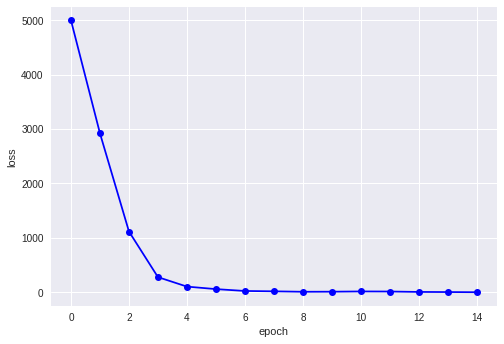

In [0]:
plt.figure()
plt.plot(epoch,loss_list,'-ob', label='Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

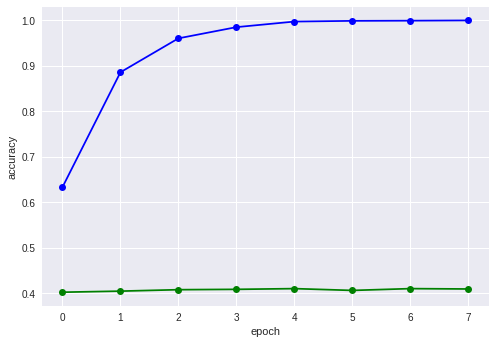

In [0]:
epoch_cap = list(range(8))
plt.figure()
plt.plot(epoch_cap,train_acc_list,'-ob', label='train')
plt.plot(epoch_cap,val_acc_list,'-og', label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [0]:
def predictTest(model, testing_data, sample_only=False):
    image_list = copy.deepcopy(test_dataset.image_list)
    predictions = []
    jpg = []
    lenTest = len(testing_data) * 1.0
    progress_print = 3
    for index, (image, label, imageName) in enumerate(testing_data):
          image = image.to(device)
          predicted = model(image)
          top5Pred, top5PredIndices = torch.topk(predicted, 5)
          for p in range(len(top5PredIndices)):
              currPred = top5PredIndices[p]
              currPred.cpu()
              relabel_whaleid = []
              for i in currPred:          
                  relabel_whaleid.append(weight_df.loc[int(i),'Id'])
              jpg.append(imageName[p])
              predictions.append(' '.join(relabel_whaleid))  
          if index % progress_print == 0:
            print(f'{index / lenTest * 100}%')
          if sample_only:
            break;
    
    whale_predictions = pd.DataFrame({'Image':jpg,'Id':predictions})
    return whale_predictions          

In [0]:
!cd /content/drive/My\ Drive/CS\ 175\ Final\ Project/data

/bin/bash: line 0: cd: /content/drive/My Drive/CS 175 Final Project/data: No such file or directory


In [78]:
final_test_predictions = predictTest(final_model, full_test_generator, False)
final_test_predictions = final_test_predictions[final_test_predictions.columns[::-1]]
print(final_test_predictions)
final_test_predictions.to_csv('rn_50submission.csv', index=False)

0.0%
3.75%
7.5%
11.25%
15.0%
18.75%
22.5%
26.25%
30.0%
33.75%
37.5%
41.25%
45.0%
48.75%
52.5%
56.25%
60.0%
63.74999999999999%
67.5%
71.25%
75.0%
78.75%
82.5%
86.25%
90.0%
93.75%
97.5%
              Image                                                 Id
0     02ef5fee0.jpg  new_whale w_9b5109b w_9c506f6 w_700ebb4 w_0369a5c
1     329746ad4.jpg  new_whale w_9b5109b w_9c506f6 w_700ebb4 w_0369a5c
2     23892fdc3.jpg  new_whale w_9b5109b w_9c506f6 w_700ebb4 w_0369a5c
3     18d0bfd1b.jpg  new_whale w_9b5109b w_9c506f6 w_700ebb4 w_0369a5c
4     013cb8d04.jpg  new_whale w_9b5109b w_9c506f6 w_700ebb4 w_0369a5c
5     8473b9c07.jpg  new_whale w_9b5109b w_9c506f6 w_700ebb4 w_0369a5c
6     4167bc057.jpg  new_whale w_9b5109b w_9c506f6 w_700ebb4 w_0369a5c
7     c75d27e8c.jpg  new_whale w_9b5109b w_9c506f6 w_700ebb4 w_0369a5c
8     4ac21b9c5.jpg  new_whale w_9b5109b w_9c506f6 w_700ebb4 w_0369a5c
9     4e4110a8c.jpg  new_whale w_9b5109b w_9c506f6 w_700ebb4 w_0369a5c
10    bf42cdb63.jpg  new_whale w_9b